# 선형회귀 예시(1) 의료비에 영향을 미치는 요인

## #01. 작업준비

### 1. 패키지 참조

In [1]:
import pandas as pd
import sys
import os 
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import helper

import numpy as np
from pandas import read_excel, DataFrame, melt, merge
from pca import pca
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

### 2. 데이터 가져오기




In [2]:
df= pd.read_excel('https://data.hossam.kr/E04/insurance.xlsx')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## #02.데이터 전처리
### 1. 데이터 프레임 복사 


In [3]:
edf = df.copy()
edf.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 1- (1). 결측치 확인

In [4]:
edf.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### 2. 범주형 타입 변환
#### 범주형 필드 이름

In [5]:
cnames = ['sex','smoker','region']


#### 범주형 칼럼 타입 전환

In [6]:
edf2 = helper.setCategory(edf,fields=cnames,labelling=False)
edf2.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

## #03. 탐색적 데이터 분석
### 1. 수치형 변수
#### 1) 기초 통계량 확인

수치형 데이터 타입은 전체적인 통계값을 파악하는 것이 좋다.

In [7]:
edf2.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


의료비지출 변수의 통계값을 살펴보면 중앙값이 $9,382이고, 평균이 $13,270인 것을 알 
수 있다. 여기서 해당 변수의 평균값이 중앙값보다 크기 때문에 의료비 분포는 
오른쪽으로 꼬리가 긴 분포를 지닐 것이다.

### 2) 전체 상자 그림

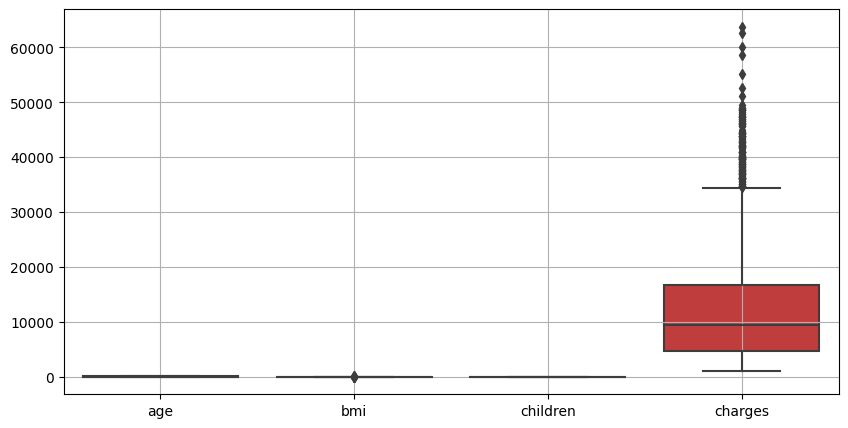

In [8]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=edf)
plt.grid()
plt.show()
plt.close()

### 3) 개별 상자 그림 확인



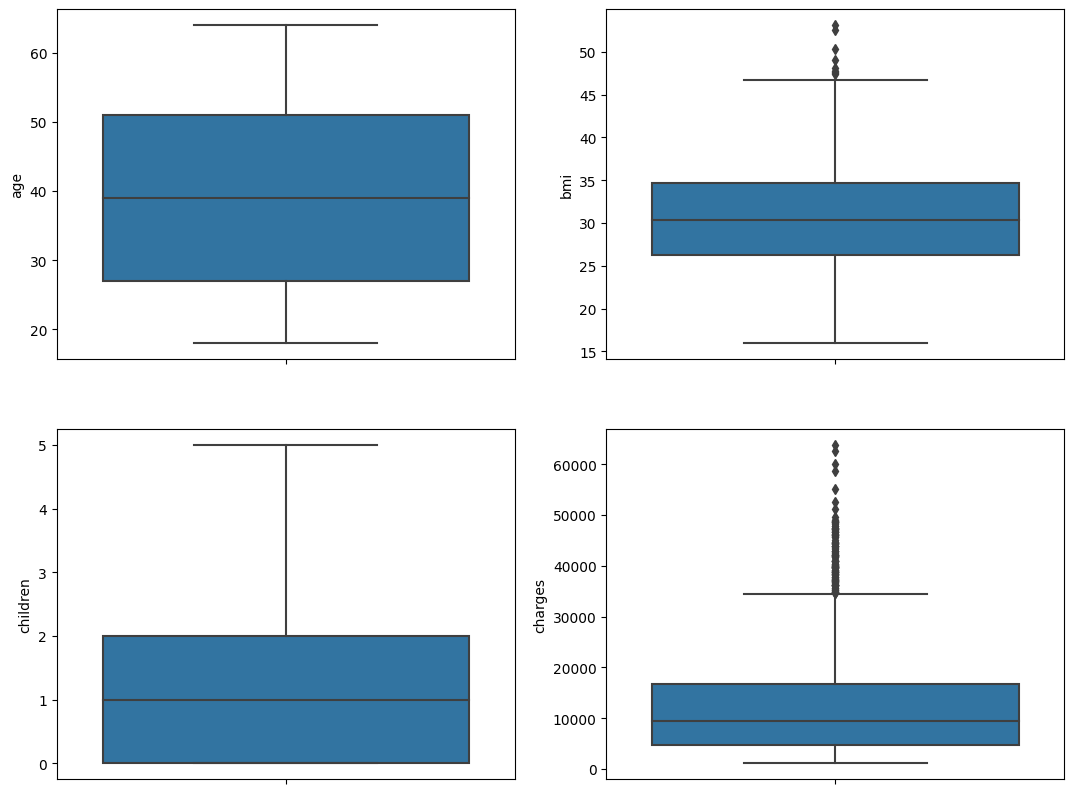

In [9]:
desc = edf.describe()
fig ,ax = plt.subplots(2,2,figsize=(13,10))
rows = len(ax)
cols = len(ax[0])

for i in range(0,rows) : 
    for j in range(0,cols):
        idx = cols * i + j
        fieldname = desc.columns[idx]
        field = edf[fieldname]
        sb.boxplot(edf,y=field,ax=ax[i][j])
        if idx + 1== len(desc.columns):
            break

plt.show()
plt.close()

### 4) 히스토그램 확인

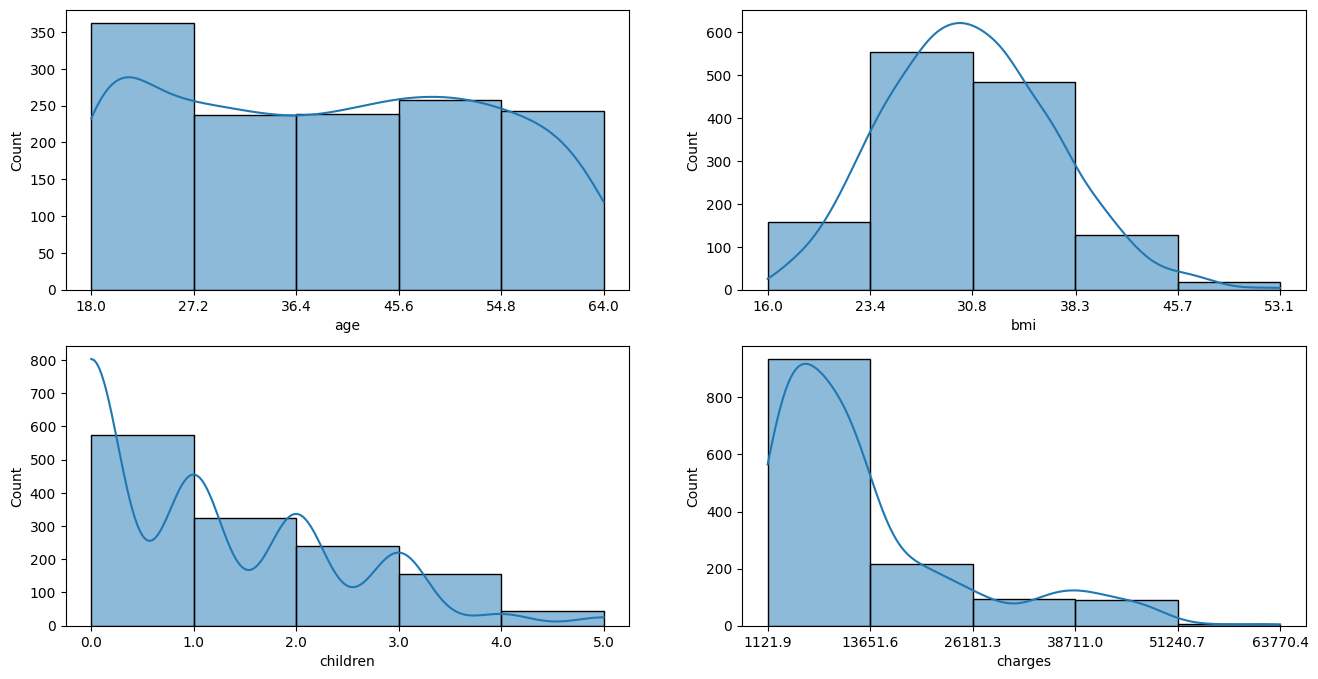

In [10]:
fig ,ax = plt.subplots(2,2,figsize = (16,8))

rows = len(ax)
cols = len(ax[0])
for i in range(0,rows):
    for j in range(0,cols):
        idx = i * cols + j 
        fieldname = desc.columns[idx]
        field = edf[fieldname]
        hist, bins = np.histogram(field,bins=5)
        bins2 = np.round(bins,1)
        sb.histplot(data = edf2 , x=fieldname, bins = 5, kde =True,ax=ax[i][j])
        ax[i][j].set_xticks(bins2)
        ax[i][j].set_xticklabels(bins2)
        if idx + 1 == len(desc.columns) :
            break

plt.show()
plt.close()

### 4) 각 변수간 관계 파악
#### 수치형 변수들의 이름


In [11]:
nnames = list(desc.columns)
nnames

['age', 'bmi', 'children', 'charges']

In [12]:

ndf = edf.filter(nnames)
ndf.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


#### 산점도 행렬
실행 속도 관계로 주석으로 막아둠

In [13]:
# plt.figure(figsize=(20, 20))
# g = sb.pairplot(ndf, diag_kind='kde')
# g.map_upper(sb.kdeplot, alpha=0.3)
# g.map_lower(sb.regplot, scatter=False, truncate=False, ci=False)
# plt.savefig("pairplot.png", dpi=200)
# plt.show()
# plt.close()

이 그림에서 어떤 패턴이 눈에 띄는지 살펴보면 특정한 관계를 찾기는 어려워보임

여기 연령과 의료비지출의 산포도를 살펴보니, 상대적으로 직선 형태로 분포되어 있음을 볼 수 있다.

또, bmi지수와 의료비지출은 크게 두 개의 군집(cluster)로 나뉘어져 있는 것으로 보인다.

전체적으로 강한 상관관계를 보이지는 않지만 age-bmi, age-charges, children-charges가 약한의 상관관계를 보인다.

나이가 들수록 몸무게가 증가하고, bmi 수치가 높거나 부양가족 수가 많아질 수록 의료비가 증가하는 것은 어느정도 합리적인 결과라 할 수 있겠다.

#### 상관행렬

In [14]:
corr = ndf.corr(method='pearson')
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000



### 5) PCA 분석
회귀분석에 필요한 요인들을 선정하기 위해 주성분 분석을 수행한다.

#### 데이터 표준화
범주형은 PCA를 수행할 수 없기 때문에 수치형 변수만 추출해 둔 ndf를 사용한다.

종속 변수인 의료비 필드는 제외하고 진행한다.

In [15]:
x_train_std_df, y_train_std_df = helper.scailing(ndf[nnames], 'charges')
x_train_std_df

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

#### PCA

In [16]:
model = pca()
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']

best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
print(best_names)

topfeat

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [3] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [3] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
['3', '1']


,PC,feature,loading,type
0,PC1,1,0.692028,best
1,PC2,3,0.931148,best
2,PC3,1,-0.717326,best
3,PC3,2,0.669385,weak


### 2.범주형 변수
#### 1) 종류별로 데이터 수량 확인

In [17]:
edf['sex'].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [18]:
edf['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [19]:
edf['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

### 2) 범주형 데이터 분포 시각화

In [20]:
edf2.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


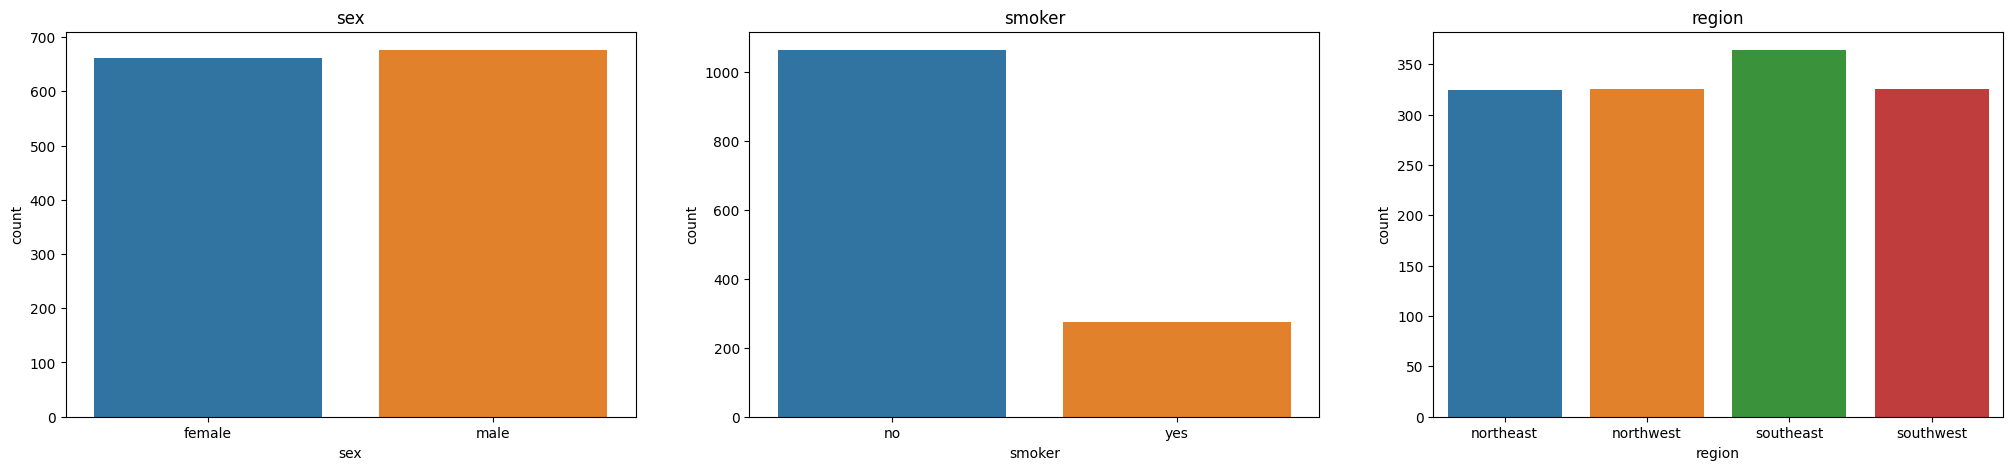

In [21]:
fig, ax = plt.subplots(1,len(cnames),figsize = (25,5))

for i , v in enumerate(cnames) :
    vc = pd.DataFrame(edf2[v].value_counts(),columns=['count'])
    sb.barplot(data = vc, x= vc.index, y= 'count',ax=ax[i])
    ax[i].set_title(v)

plt.show()
plt.close()

흡연 여부의 경우 비흡연자가 많이 분포되어 있다.

그 밖에 성별과 지역의 경우 비슷하게 분포되어 있기 때문에 분산분석을 통해 통제요인으로 넣는 것을 고려해 볼 수 있겠다.

### 3) 범주형 변수에 따라 평균이 차이가 나는지 확인하기 
#### 라벨링을 적용한 데이터프레임 생성


In [22]:
ldf = helper.setCategory(edf,fields=cnames,labelling=True)
ldf.dtypes

age           int64
sex           int32
bmi         float64
children      int64
smoker        int32
region        int32
charges     float64
dtype: object

#### 분산분석

In [23]:
lm = ols('charges ~ C(sex)+C(smoker)+C(region)+C(sex):C(smoker)+C(smoker):C(region)+C(region):C(sex)+C(sex):C(smoker):C(region)', data=ldf).fit()
lmdf = anova_lm(lm)
lmdf['결과'] = lmdf['PR(>F)'] < 0.05
lmdf

,df,sum_sq,mean_sq,F,PR(>F),결과
C(sex),1.0,6.435902e+08,6.435902e+08,11.730026,6.338371e-04,True
C(smoker),1.0,1.208777e+11,1.208777e+11,2203.108485,7.872124e-284,True
C(region),3.0,1.078004e+08,3.593345e+07,0.654920,5.799028e-01,False
C(sex):C(smoker),1.0,4.904163e+08,4.904163e+08,8.938290,2.844155e-03,True
C(smoker):C(region),3.0,1.344084e+09,4.480281e+08,8.165726,2.181106e-05,True
C(region):C(sex),3.0,1.382281e+06,4.607604e+05,0.008398,9.989439e-01,False
C(sex):C(smoker):C(region),3.0,7.517058e+07,2.505686e+07,0.456684,7.126143e-01,False
Residual,1322.0,7.253404e+10,5.486690e+07,NaN,NaN,False


성별과 흡연 여부에 대한 p값이 모두 0.05 미만이므로 두 요인은 의료비 지출에 통계적으로 유의미한 영향을 미친다고 볼 수 있다.

성별과 흡연량, 흡연량과 지역 간에는 교효작용 효과가 있음이 발견되었다.

#### 교호작용을 보이는 변수간의 비교

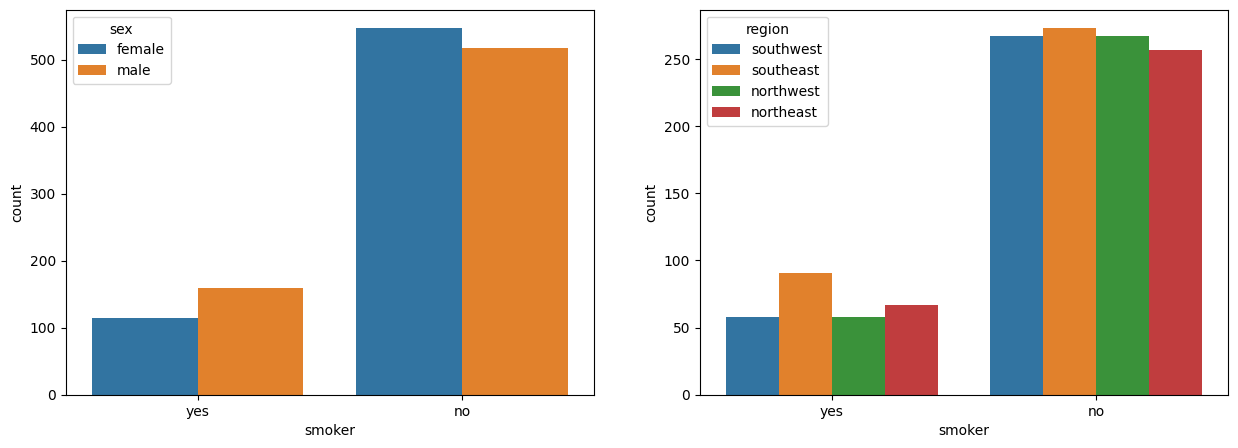

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sb.countplot(data=edf, x='smoker', hue='sex', ax=ax1)    
sb.countplot(data=edf, x='smoker', hue='region', ax=ax2)

plt.show()
plt.close()

## #04. 최종적으로 선정된 요인

|구분	|변수	|의미	|기타|
|--|--|--|--|
|종속변수	|expense|	의료비	|수치형 데이터|
|독립변수	|age	|수익자의 연령	|수치형|
|독립변수	|bmi	|미만도. 몸무게를 키의 제곱으로 나눈 값.	|수치형:정상범위: 18.5~24.9|
|독립변수|	children|	의료보험이 적용되는 자녀 수|	수치형 데이터|
|통제요인|	sex	|계약자의 성별	|범주형 데이터(female/male)|
|통제요인|	smoker|	흡연 여부|	범주형 데이터(yes/no)|

## #05. 다중선형회귀분석

- case 1 : 모든 변수 적용
- case 2 : bmi를 제거하고 적용
- case 3 : 모든 변수 적용 + 표준화 적용
- case 4 : bmi를 제거하고 적용 + 표준화 적용

### 1. 분석 케이스에 따른 분석용 데이터 생성

In [25]:
def get_df(case_number,is_scale = False):
    # bmi를 제거하지 않은 경우
    if case_number == 1:
        ### 사용할 변수 이름들
        fnames1 = ['charges','age','bmi','children','sex','smoker']
        ### fnames1 중에서 더미변수로 처리할 변수들
        fnames2 = ['sex','smoker']
    # bmi 제거한 경우
    elif case_number == 2 : 
        fnames1 = ['charges','age','children','sex','smoker']
        fnames2 = ['sex','smoker']
    ## 성별을 제거한 경우
    elif case_number == 3 :
        fnames1 = ['charges','age','bmi','children','smoker']
        fnames2 = ['smoker']
    ## 성별과 bmi를 제거
    elif case_number == 4 :
        fnames1 = ['charges','age','children','smoker']
        fnames2 = ['smoker']
    
    ## 표준화 적용하지 않은 경우
    if not is_scale :
        tmp = df.filter(fnames1)
    ## 표준화 적용한 경우

    else : 
        ## 미리 적용해 둔 표준화 결과를 병합
        left = pd.merge(x_train_std_df,y_train_std_df,left_index=True,right_index=True).filter(fnames1)
        ## d원본에서 명목형만 추출
        right = df.filter(fnames2)
        # 결합
        tmp = pd.merge(left,right,left_index=True,right_index=True)
        None
    tmp2 = pd.get_dummies(tmp,columns=fnames2,drop_first=True,dtype='int')
    return tmp2


In [26]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [27]:
y_train_std_df = pd.DataFrame(y_train_std_df,columns=['charges'])
y_train_std_df.head()

,charges
0,0.298584
1,-0.953689
2,-0.728675
3,0.719843
4,-0.776802


In [28]:
x_train_std_df = pd.DataFrame(x_train_std_df,columns=['age','bmi','children'])
x_train_std_df.head()

,age,bmi,children
0,-1.438764,-0.453320,-0.908614
1,-1.509965,0.509621,-0.078767
2,-0.797954,0.383307,1.580926
3,-0.441948,-1.305531,-0.908614
4,-0.513149,-0.292556,-0.908614


In [29]:
target_df = get_df(3, True)
target_df.head()

# 독립변수 이름만 추출
xnames = list(target_df.columns)
xnames.remove('charges')
#xnames

ols_result = helper.my_ols(target_df, y='charges', x=xnames)
ols_result.table
print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

                          B   표준오차  β         t   유의확률       VIF
종속변수    독립변수                                                    
charges Intercept   -0.4028  0.015  0  -26.211*  0.000  0.000000
        age          0.2992  0.014  0   21.675*  0.000  1.243647
        bmi          0.1621  0.014  0   11.756*  0.000  1.082342
        children     0.0471  0.014  0    3.436*  0.001  1.008148
        smoker_yes   1.9670  0.034  0   57.904*  0.000  2.321101

charges에 대하여 age,bmi,children,smoker_yes로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,1333) = 998.1, p < 0.05).

age의 회귀계수는 0.2992(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 0.1621(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
children의 회귀계수는 0.0471(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
smoker_yes의 회귀계수는 1.9670(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.


### 3. 결과 비교
#### 1) 나이에 따른 의료비 지출


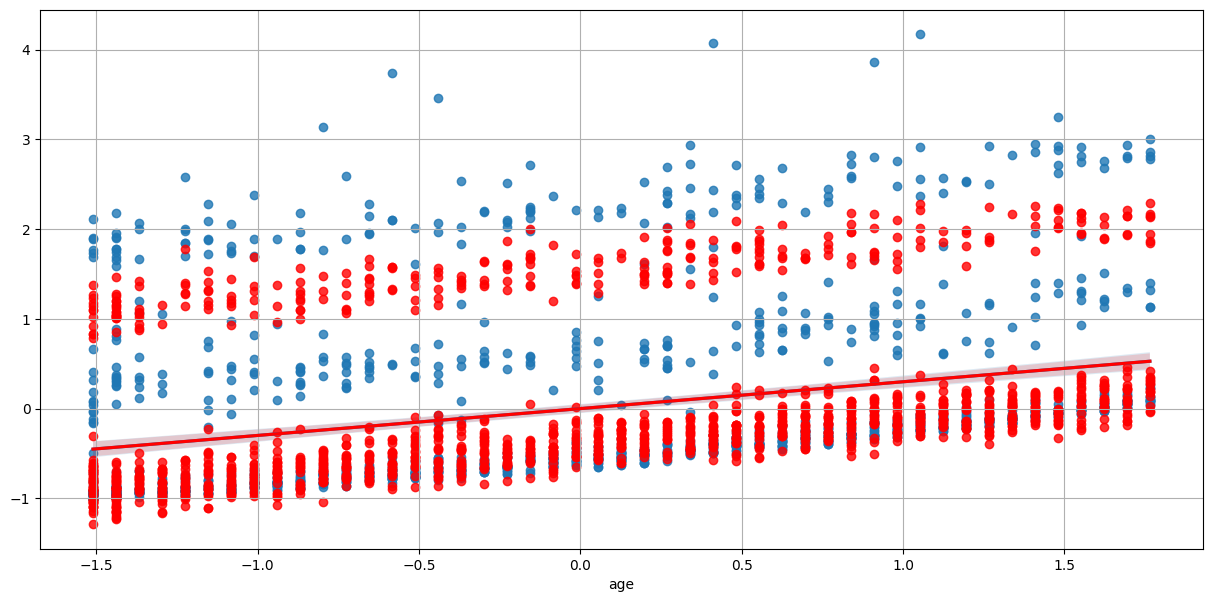

In [30]:
plt.figure(figsize=(15, 7))
sb.regplot(data=target_df, x='age', y='charges')
sb.regplot(data=target_df, x='age', y=ols_result.fit.fittedvalues, color='red')
plt.grid()
plt.plot()
plt.show()

### 2) BMI에 따른 의료비 지출


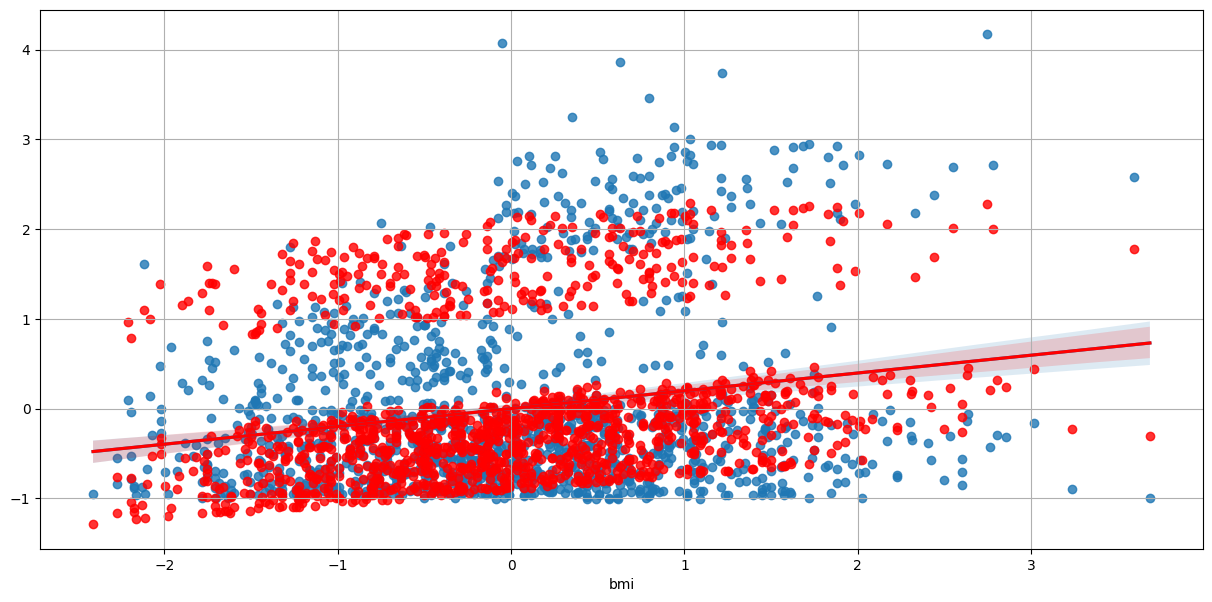

In [31]:
plt.figure(figsize=(15, 7))
sb.regplot(data=target_df, x='bmi', y='charges')
sb.regplot(data=target_df, x='bmi', y=ols_result.fit.fittedvalues, color='red')
plt.grid()
plt.plot()
plt.show()

## #06. 데이터 도메인 지식
도메인 지식이란 특정 분야의 전문화된 지식.

ex) 노하우

도메인 지식을 활용하면 도출된 분석모델의 성능을 개선할 수 있다.

### 1. 의료비 지출
의료비 지출에 대한 연령의 영향은 전 연령에 걸쳐 일정하지 않다.

20,30대와 50,60,70대 간의 의료비 지출 차이는 크게 날 수 밖에 없다.

기존의 연령변수는 전형적인 선형회귀 방정식을 따른다.


하지만 고연령대일수록 증가푝이 커지는 현상을 설명하기 위해서는 높은 차수의 항을 회귀 모델에 추가해서 다항식으로 만들어 주면 된다.


연령을 제곱한 형태로 연령 변수 교체

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
tmp_df = pd.DataFrame({'age2': df['age'] ** 2}, index=df.index)
age2_std = StandardScaler().fit_transform(tmp_df)
target_df['age'] = age2_std
target_df.head()

,charges,age,bmi,children,smoker_yes
0,0.298584,-1.220462,-0.453320,-0.908614,1
1,-0.953689,-1.253341,0.509621,-0.078767,0
2,-0.728675,-0.844579,0.383307,1.580926,0
3,0.719843,-0.573551,-1.305531,-0.908614,0
4,-0.776802,-0.631311,-0.292556,-0.908614,0


#### 회귀분석 수행

In [34]:
xnames = list(target_df.columns)
xnames.remove('charges')

ols_result = helper.my_ols(target_df, y='charges', x=xnames)


print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

                          B   표준오차  β         t   유의확률       VIF
종속변수    독립변수                                                    
charges Intercept   -0.4030  0.015  0  -26.367*  0.000  0.000000
        age          0.3036  0.014  0   22.129*  0.000  1.251226
        bmi          0.1603  0.014  0   11.689*  0.000  1.082276
        children     0.0608  0.014  0    4.464*  0.000  1.010457
        smoker_yes   1.9679  0.034  0   58.247*  0.000  2.331466

charges에 대하여 age,bmi,children,smoker_yes로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(4,1333) = 1013., p < 0.05).

age의 회귀계수는 0.3036(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 0.1603(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
children의 회귀계수는 0.0608(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
smoker_yes의 회귀계수는 1.9679(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.


### 2. 비만도(BMI)
BMI는 특정 구간에서의 영향은 적지만 그 구간을 넘어가면 강한 영향을 미친다.

EDA를 진행하는 과정에서 BMI가 30이상인 사람과 30 미만인 사람들을 구분할 수 있음을 파악하였다.

이 내용을 더미변수로 추가할 수 있다.

BMI에 대한 비만도 파생 변수 만들기

In [35]:
tmp_df = df.filter(['bmi'])
tmp_df['obesity'] = tmp_df['bmi'] >= 30
tmp_df['obesity'] = tmp_df['obesity'].astype(int)
tmp_df

,bmi,obesity
0,27.900,0
1,33.770,1
2,33.000,1
3,22.705,0
4,28.880,0
...,...,...
1333,30.970,1
1334,31.920,1
1335,36.850,1
1336,25.800,0


In [36]:
target_df['obesity'] = tmp_df['obesity']
target_df.head()

,charges,age,bmi,children,smoker_yes,obesity
0,0.298584,-1.220462,-0.453320,-0.908614,1,0
1,-0.953689,-1.253341,0.509621,-0.078767,0,1
2,-0.728675,-0.844579,0.383307,1.580926,0,1
3,0.719843,-0.573551,-1.305531,-0.908614,0,0
4,-0.776802,-0.631311,-0.292556,-0.908614,0,0


#### 회귀분석 수행

In [37]:
xnames = list(target_df.columns)
xnames.remove('charges')

ols_result = helper.my_ols(target_df, y='charges', x=xnames)

print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

                          B   표준오차  β         t   유의확률       VIF
종속변수    독립변수                                                    
charges Intercept   -0.5248  0.028  0  -18.605*  0.000  0.000000
        age          0.3032  0.014  0   22.302*  0.000  1.313720
        bmi          0.0685  0.023  0    3.043*  0.002  1.920042
        children     0.0609  0.014  0    4.509*  0.000  1.012493
        smoker_yes   1.9684  0.033  0   58.813*  0.000  3.388612
        obesity      0.2304  0.045  0    5.119*  0.000  2.082544

charges에 대하여 age,bmi,children,smoker_yes,obesity로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(5,1332) = 830.8, p < 0.05).

age의 회귀계수는 0.3032(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
bmi의 회귀계수는 0.0685(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
children의 회귀계수는 0.0609(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
smoker_yes의 회귀계수는 1.9684(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.
obesity의 회귀계수는 0.2304(p<0.05)로, charges에 대하여 유의미한 예측변인인 것으로 나타났다.


### 3. 교호작용 추가

비만도와 흡연여부

In [41]:
xnames = list(target_df.columns)
xnames.remove('charges')

ols_result = ols(data = target_df, "ycharges~age+bmi+children+smoker_yes+obesity+bmi*smoker_yes")

# ols_result.table
print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

TypeError: Model.from_formula() missing 1 required positional argument: 'data'

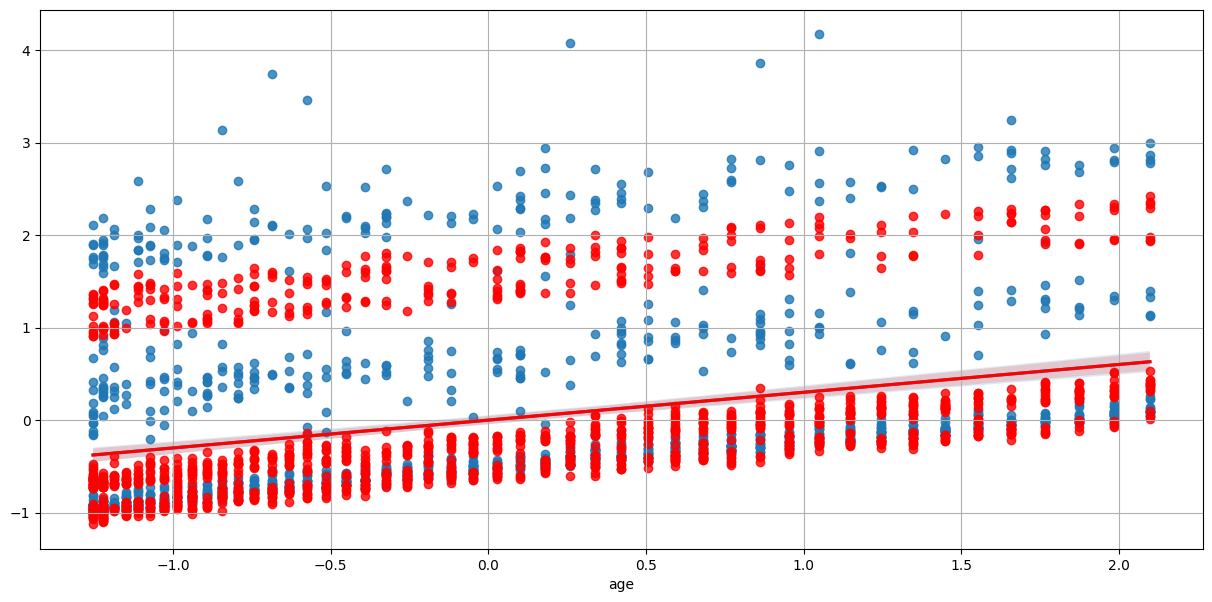

In [40]:
plt.figure(figsize=(15, 7))
sb.regplot(data=target_df, x='age', y='charges')
sb.regplot(data=target_df, x='age', y=ols_result.fit.fittedvalues, color='red')
plt.grid()
plt.plot()
plt.show()